In [1]:
!pip install -qqq git+https://github.com/chalk-diagrams/chalk git+https://github.com/srush/RASPy 

In [2]:
from raspy import *
from raspy.rasp import Seq, Sel, SOp, Key, Query
from raspy.visualize import draw_all, draw, draw_sel
from chalk import *
from colour import Color
from raspy.visualize import word

def draw(c_inp=Color("white"), c_att=Color("white"), c_back=Color("white"), c_ffn=Color("white")):

    d =  box("Input", c_inp).named("inp") / vstrut(1) / (rectangle(3, 4).fill_color(c_back).named("main") +  ( box("Feed Forward", c_ffn).named("ffn") / vstrut(1) / box("Attention", c_att).named("att")).center_xy()) / vstrut(1) / box("Final").named("final")
    return d.connect_outside("inp", "main").connect_outside("ffn", "att").connect_outside("main", "final")

def draw_att():
    d = rectangle(2.5, 2.5)
    d = d.beside(box2("query", green).rotate_by(0.25).named("query"), -unit_x)
    d = d.beside(box2("key", orange).named("key"), -unit_y)
    d = d.beside(box2("output").rotate_by(-0.25).named("output"), unit_x)
    d = d.beside(box2("value", red).named("value"), unit_y)
    d = d + rectangle(0.4,0.4).fill_color(black).named("mid").translate(-0.5, 0)
    d = d + rectangle(0.4,0.4).fill_color(black).named("mid2").translate(0.5, 0)
    d = d.connect_perim("key", "mid", unit_y, -unit_y).connect_outside("query", "mid").connect_outside("mid", "mid2").connect_perim("value", "mid2", -unit_y, unit_y).connect_outside("mid2", "output")
    return d
set_svg_height(400)

# Thinking Like Transformers

- [Paper](https://arxiv.org/pdf/2106.06981.pdf) by Gail Weiss, Yoav Goldberg, Eran Yahav
- Blog by [Sasha Rush](https://rush-nlp.com/) and [Gail Weiss](https://sgailw.cswp.cs.technion.ac.il/)
- Library and Interactive Notebook: [srush/raspy](https://github.com/srush/RASPy)

Transformer models are foundational to AI systems. There are now countless explanations of "how transformers work?" in the sense of the architecture diagram at the heart of transformers.

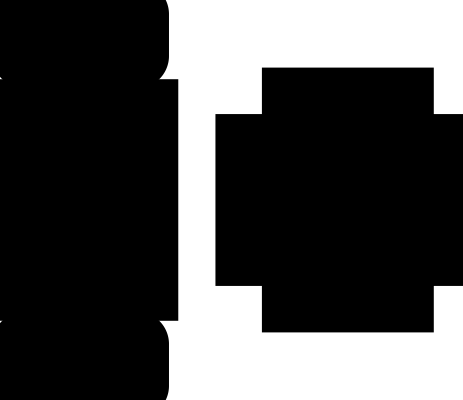

In [3]:
draw(c_att=Color("lightgray")).center_xy() | hstrut(2) | draw_att().center_xy()

However this diagram does not provide any intuition into the computational model of this framework. As researchers become interested in how Transformers work, gaining intuition into their mechanisms becomes increasingly useful.

[Thinking like Transformers](https://arxiv.org/pdf/2106.06981.pdf) proposes a computational framework for  Transformer-like calculations. The framework uses discrete computation to simulate Transformer computations.  The resulting language [RASP](https://github.com/tech-srl/RASP) is a programming language where every program compiles down to a specific Transformer.

In this blog post, I reimplemented a variant of RASP in Python ([RASPy](https://github.com/srush/raspy)). The language is roughly compatible with the original version, but with some syntactic changes that I thought were fun. With this language, the author of the work Gail Weiss, provided a challenging set of puzzles to walk through and understand how it works. 

In [4]:
#!pip install git+https://github.com/srush/RASPy

Before jumping into the language itself, let's look at an example of what coding with Transformers looks like. Here is some code that computes the `flip`, i.e. reversing an input sequence. The code itself uses two Transformer layers to apply attention and mathematical computations to achieve the result.

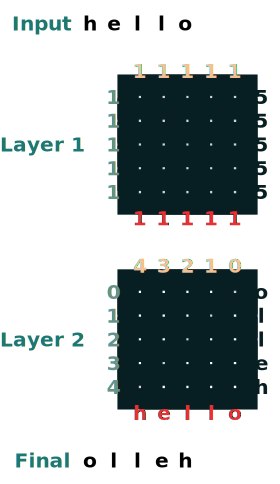

In [5]:
def flip():
    length = (key(1) == query(1)).value(1)
    flip = (key(length - indices - 1) == query(indices)).value(tokens)
    return flip
flip()

<h2 id="table-of-contents">Table of Contents</h2>
<ul>
<li>Part 1: <a href="#transformers-as-code">Transformers as Code</a></li>
<li>Part 2: <a href="#coding-with-transformers">Coding with Transformers</a></li>
</ul>


## Transformers as Code

Our goal is to define a computational formalism that mimics the expressivity of Transformers. We will go through this process by analogy, describing each language construct next to the aspect of the Transformer it represents. (See the full [paper](https://arxiv.org/pdf/2106.06981.pdf) for the formal language specification).

The core unit of the language is a *sequence operation* that transforms a sequence to another sequence of the same length. I will refer to these throughout as *transforms*.

### Inputs

In a Transformer, the base layer is the input fed to the model. This input usually contains the raw tokens as well as positional information.  

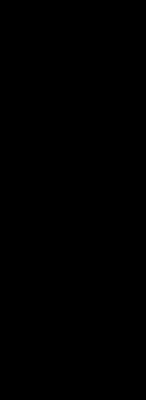

In [6]:
draw(orange)

In code, the symbol `tokens` represents the simplest transform. It returns the tokens passed to the model. The default input is the sequence "hello". 

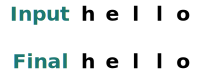

In [7]:
tokens

If we want to change the input to the transform, we use the input method to pass in an alternative. 

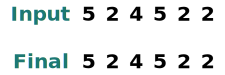

In [8]:
tokens.input([5, 2, 4, 5, 2, 2])

As with Transformers, we cannot access the positions of these sequences directly. However, to mimic position embeddings, we have access to a sequence of indices.

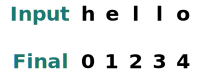

In [9]:
indices

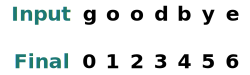

In [10]:
sop = indices
sop.input("goodbye")

### Feed Forward Network

After the input layer, we reach the feed-forward network. In a Transformer, this stage can apply mathematical operations to each element of the sequence independently. 

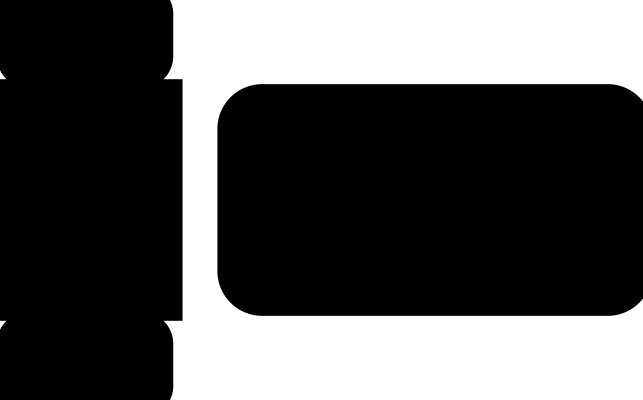

In [11]:
right = ( hcat([box("x" + str(i)).named("x"+str(i)) for i in range(3)],0.5) / vstrut(1) / hcat([box("x" + str(i) + "'").named("x'"+str(i)) for i in range(3)],0.5)) 
right = rectangle(9, 4, 0.5).fill_color(orange) + right.center_xy()
d = draw(c_ffn=orange).center_xy().scale(0.8) | hstrut(1.5) | right.center_xy().scale(0.7)
for i in range(3):
    d = d.connect_outside("x" + str(i), "x'"+str(i))
d

In code, we represent this stage by computation on transforms. Mathematical operations are overloaded to represent independent computation on each element of the sequence .

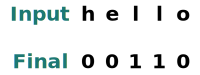

In [12]:
tokens == "l"

The result is a new transform. Once constructed it can be applied to new input.

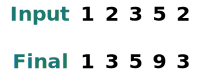

In [13]:
model = tokens * 2  - 1
model.input([1, 2, 3, 5, 2])

Operations can combine multiple transforms. For example, functions of `tokens` and `indices`. The analogy here is that the Transformer activations can keep track of multiple pieces of information simultaneously.

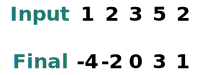

In [14]:
model = tokens - 5 + indices
model.input([1, 2, 3, 5, 2])

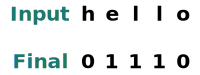

In [15]:
(tokens == "l") | (indices == 1)

We provide a few helper functions to make it easier to write transforms. For example, `where` provides an "if" statement like construct

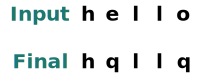

In [16]:
where((tokens == "h") | (tokens == "l"), tokens, "q")

And `map` lets us define our own operators, for instance a string to int transform. (Users should be careful to only use operations here that could be computed with a simple neural network).

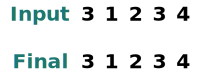

In [17]:
atoi = tokens.map(lambda x: ord(x) - ord('0'))
atoi.input("31234")

When chaining these transforms, it is often easier to write as functions. For example the following applies where and then `atoi` and then adds 2. 

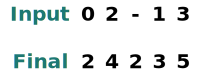

In [18]:
def atoi(seq=tokens):
    return seq.map(lambda x: ord(x) - ord('0')) 

op = (atoi(where(tokens == "-", "0", tokens)) + 2)
op.input("02-13")

###  Attention Selectors

Things get more interesting when we start to apply attention. This allows routing of information between the different elements of the sequence. 

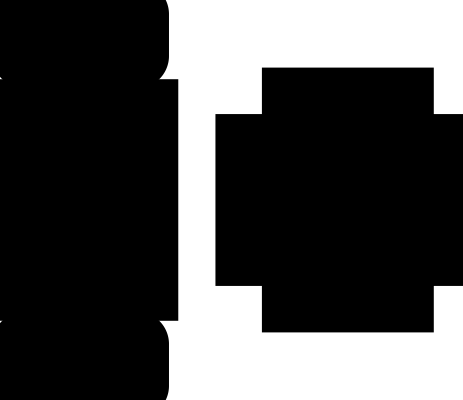

In [19]:
draw(c_att=orange).center_xy() | hstrut(2) | draw_att().center_xy()

We begin by defining notation for the keys and queries of the model. Keys and Queries can be created directly from the transforms defined above. For example if we want to define a key we call `key`.

In [20]:
key(tokens)

Similarly for `query`.

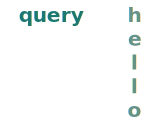

In [21]:
query(tokens)

Scalars can be used as keys or queries. They broadcast out to the length of the underlying sequence.

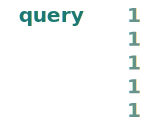

In [22]:
query(1)

By applying an operation between a keys and queries we create a *selector*. This corresponds to a binary matrix indicating which keys each query is attending to. Unlike in Transformers, this attention matrix is unweighted.

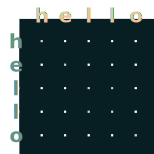

In [23]:
eq = (key(tokens) == query(tokens))
eq

Some examples: 

* A selector the matches positions offset by 1.

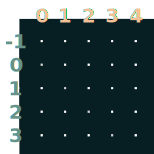

In [24]:
offset = (key(indices) == query(indices - 1))
offset

* A selector that matches to keys earlier in time. 

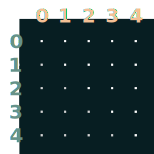

In [25]:
before = key(indices) < query(indices)
before

* A selector that matches to keys later in time.

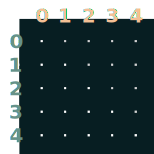

In [26]:
after = key(indices) > query(indices)
after

Selectors can be merged with boolean operations. For example, this selector attends only to tokens before it in time with the same value. We show this by including both pairs of keys and values in the matrix.

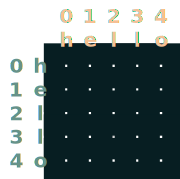

In [27]:
before & eq

## Using Attention 

Given an attention selector we can provide a value sequence to aggregate. We represent aggregation by **summing** up over the values that have a true value for their selector. 

(Note: in the original paper, they use a **mean** aggregation and show a clever construction where mean aggregation is able to represent a sum calculation. RASPy uses sum by default for simplicity and to avoid fractions. In practicce this means that RASPy may underestimate the number of layers needed to convert to a mean based model by a factor of 2.)

Attention aggregation gives us the ability to compute functions like histograms. 

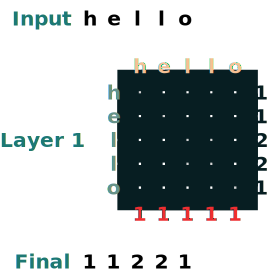

In [28]:
(key(tokens) == query(tokens)).value(1)

Visually we follow the architecture diagram. Queries are to the left, Keys at the top, Values at the bottom, and the Output is to the right.

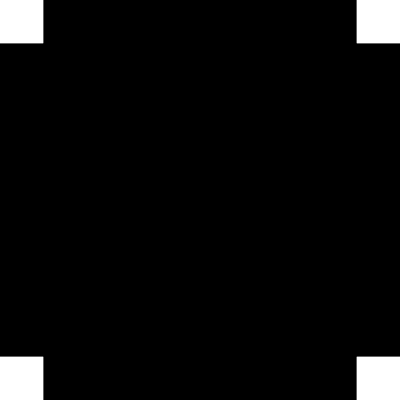

In [29]:
draw_att().center_xy()

Some attention operations may not even use the input tokens. For instance to compute the `length` of a sequence, we create a "select all" attention selector and then add the values.

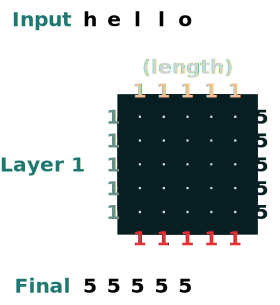

In [30]:
length = (key(1) == query(1)).value(1)
length = length.name("length")
length

Here's a more complex example, shown step-by-step. (This is the kind of thing they ask in interviews!)

Say we want to compute the sum of neighboring values in a sequence. First we apply the forward cutoff. 

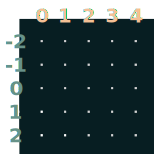

In [31]:
WINDOW=3
s1 = (key(indices) >= query(indices - WINDOW + 1))  
s1

Then the backward cutoff. 

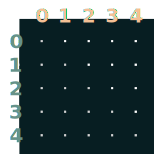

In [32]:
s2 = (key(indices) <= query(indices))
s2

Intersect.

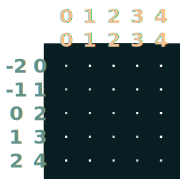

In [33]:
sel = s1 & s2
sel

And finally aggregate.

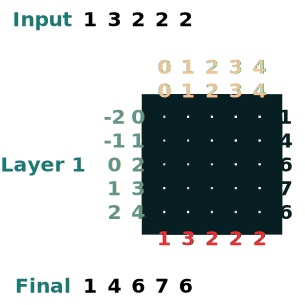

In [34]:
sum2 = sel.value(tokens) 
sum2.input([1,3,2,2,2])

Here's a similar example with a cumulative sum. We introduce here the ability to `name` a transform which helps with debugging.

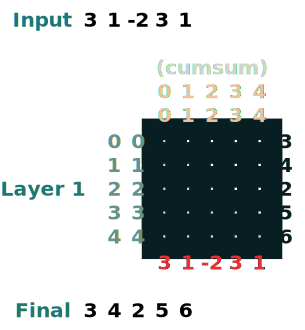

In [35]:
def cumsum(seq=tokens):
    x = (before | (key(indices) == query(indices))).value(seq)
    return x.name("cumsum")
cumsum().input([3, 1, -2, 3, 1])

## Layers 

The language supports building up more complex transforms. It keeps track of the *layers* by tracking the operations computed so far. 

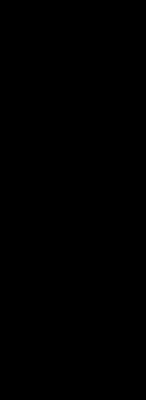

In [36]:
draw(c_back=orange)

Here is a simple example that produces a 2-layer transform. The first corresponds to computing length and the second the cumulative sum.

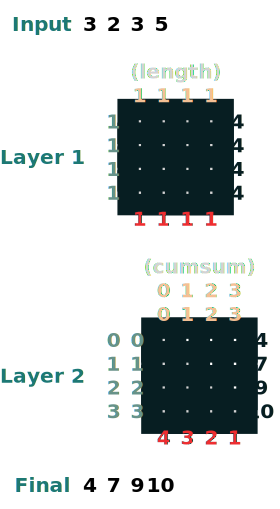

In [37]:
x = cumsum(length - indices)
x.input([3, 2, 3, 5])

## Coding with Transformers

Given this library of functions, we can write operations to accomplish surprisingly complex tasks. 

Gail Weiss, gave me a really challenging problem broken up into steps. 

**Can we produce a Transformer that does basic addition of arbitrary length numbers?**

i.e. given a string "19492+23919" can we produce the correct output? 

If you would rather do these on your own, we provide [a version](https://colab.research.google.com/github/srush/raspy/blob/main/Blog.ipynb) where you can try these yourself.

### Challenge 1: Select a given index

Produce a sequence where all the elements have the value at index i.

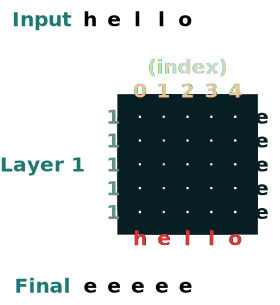

In [38]:
def index(i, seq=tokens):
    x = (key(indices) == query(i)).value(seq)
    return x.name("index")
index(1)

### Challenge 2: Shift

Shift all of the tokens in a sequence to the right by `i` positions.

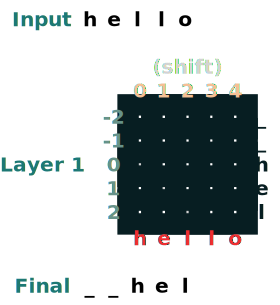

In [39]:
def shift(i=1, default="_", seq=tokens):
    x = (key(indices) == query(indices-i)).value(seq, default)
    return x.name("shift")
shift(2)

### Challenge 3: Minimum 

Compute the minimum values of the sequence. (This one starts to get harder. Our version uses 2 layers of attention.)

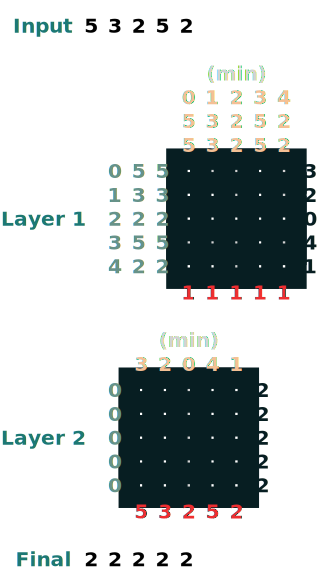

In [40]:
def minimum(seq=tokens):
    sel1 = before & (key(seq) == query(seq))
    sel2 = key(seq) < query(seq)
    less = (sel1 | sel2).value(1)
    x = (key(less) == query(0)).value(seq)
    return x.name("min")
minimum()([5,3,2,5,2])

### Challenge 4: First Index

Compute the first index that has token `q`. (2 layers)

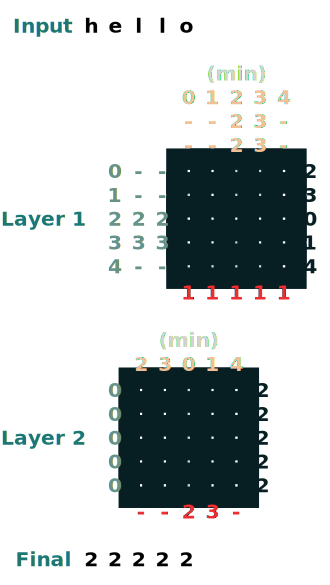

In [41]:
def first(q, seq=tokens):
    return minimum(where(seq == q, indices, 99))
first("l")

### Challenge 5: Right Align

Right align a padded sequence e.g. ralign().inputs('xyz___') = '---xyz'" (2 layers)

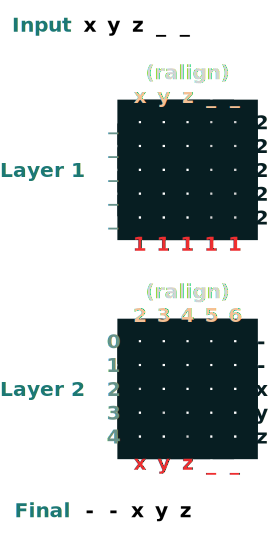

In [42]:
def ralign(default="-", sop=tokens):
    c = (key(sop) == query("_")).value(1)
    x = (key(indices + c) == query(indices)).value(sop, default)
    return x.name("ralign")
ralign()("xyz__")

### Challenge 6: Split

Split a sequence into two parts at token "v" and then right align. (2 layers)

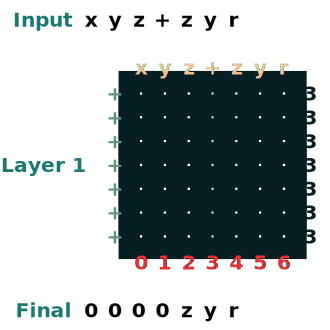

In [43]:
def split(v, i, sop=tokens):

    mid = (key(sop) == query(v)).value(indices)
    if i == 0:
        x = ralign("0", where(indices < mid, sop, "_"))
        return x
    else:
        x = where(indices > mid, sop, "0")
        return x
split("+", 1)("xyz+zyr")

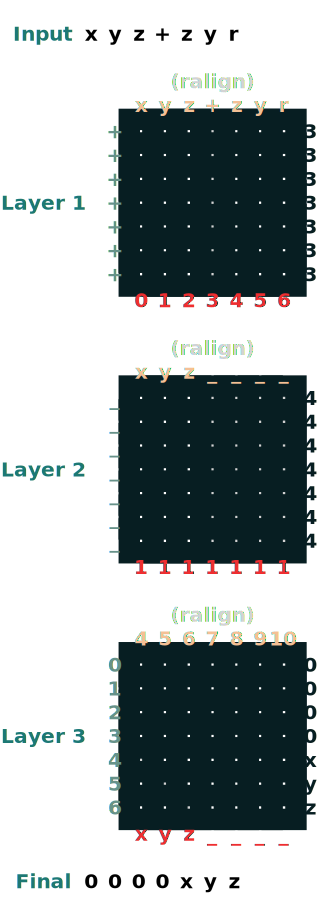

In [44]:
split("+", 0)("xyz+zyr")

### Challenge 6: Slide

Replace special tokens "<" with the closest non "<" value to their right. (2 layers)

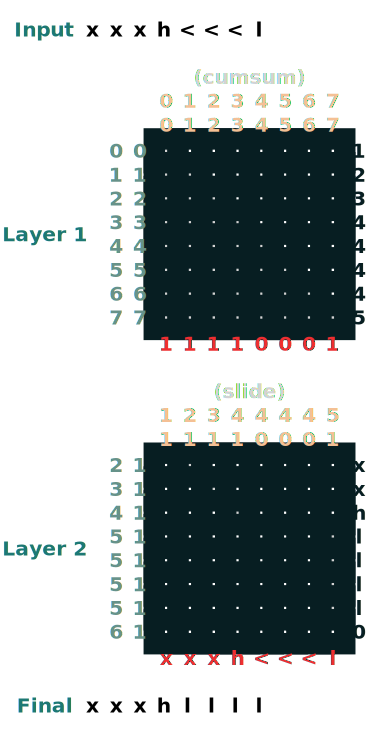

In [45]:
def slide(match, seq=tokens):
    x = cumsum(match) 
    y = ((key(x) == query(x + 1)) & (key(match) == query(True))).value(seq)
    seq =  where(match, seq, y)
    return seq.name("slide")
slide(tokens != "<").input("xxxh<<<l")

### Challenge 7: Add

For this one you want to perform addition of two numbers. Here are the steps. 

```python
add().input("683+345")
```

0) Split into parts. Convert to ints. Add

> "683+345" => [0, 0, 0, 9, 12, 8]

1) Compute the carry terms. Three possibilities: 1 has carry, 0 no carry, < maybe has carry. 

> [0, 0, 0, 9, 12, 8] => "00<100"

2) Slide the carry coefficients

> "00<100" => 001100"

3) Complete the addition.

Each of these is 1 line of code. The full system is 6 attentions. (Although Gail says that if you are careful you can do it in 5!). 



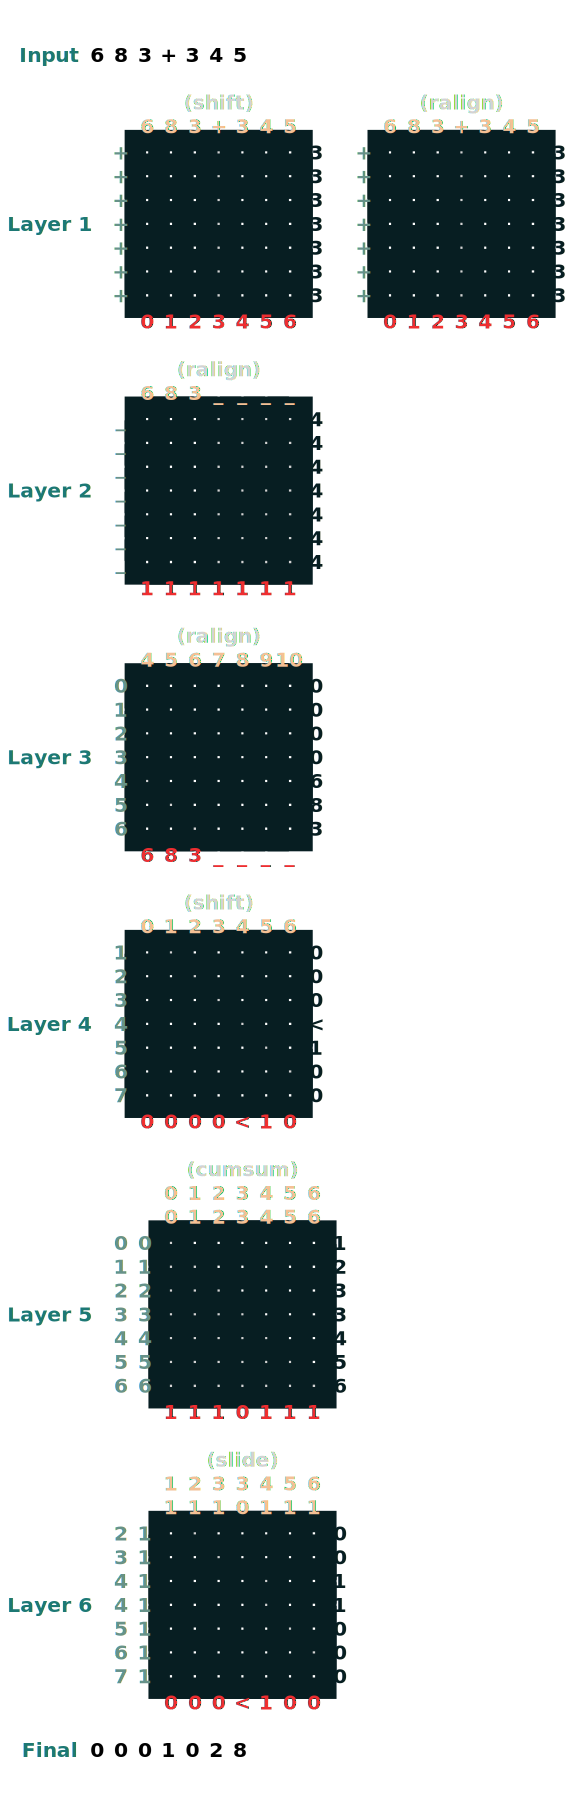

In [46]:
def add(sop=tokens):
    # 0) Parse and add
    x = atoi(split("+", 0, sop)) + atoi(split("+", 1, sop))
    # 1) Check for carries 
    carry = shift(-1, "0", where(x > 9, "1", where(x == 9, "<", "0")))
    # 2) In parallel, slide carries to their column                                         
    carries = atoi(slide(carry != "<", carry))
    # 3) Add in carries.                                                                                  
    return (x + carries) % 10
add()("683+345")

In [47]:
683 + 345

1028

Pretty neat stuff. If you are interested more in this topic, be sure to check at the paper: 

[Thinking like Transformers](https://arxiv.org/pdf/2106.06981.pdf) and the [RASP language](https://github.com/tech-srl/RASP).


If you're generally interested in the connection of formal languages and neural networks (FLaNN), or know people who are, there is an online community for exactly that, which has been very friendly and reasonably active so far!

Check it out at https://flann.super.site/ . 


This blog post, including the library, visualization and blog post is available at https://github.com/srush/raspy .
